# Предобученный UNet для семантической сегментации

В этом ноутбуке мы реализуем обучение предобученной модели UNet для семантической сегментации на датасете CamVid. Используем PyTorch Lightning для обучения модели.


## Установка зависимостей

Устанавливаем библиотеку segmentation_models_pytorch для работы с предобученными моделями сегментации.


In [2]:
!pip install -q segmentation-models-pytorch albumentations
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 39.2 MB/s eta 0:00:00


In [3]:
import os
import shutil
import zipfile
import requests
from tqdm import tqdm

def download_full_camvid():
    """Загружает полный датасет CamVid с kaggle"""
    print("Загрузка полного датасета CamVid...")

    # Удаляем старые данные
    if os.path.exists('/content/CamVid'):
        shutil.rmtree('/content/CamVid')

    # Создаем временную папку
    temp_dir = '/content/temp_camvid'
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    os.makedirs(temp_dir, exist_ok=True)

    url = "https://www.kaggle.com/api/v1/datasets/download/carlolepelaars/camvid"
    zip_path = os.path.join(temp_dir, "master.zip")

    print("Скачивание...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(zip_path, 'wb') as f, tqdm(
        desc="Прогресс",
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for data in response.iter_content(chunk_size=1024):
            f.write(data)
            pbar.update(len(data))

    # Распаковываем
    print("Распаковка...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Основной путь к данным
    source_dir = os.path.join(temp_dir, 'CamVid')

    # Создаем целевую структуру
    target_dir = '/content/CamVid'
    os.makedirs(target_dir, exist_ok=True)

    # Соответствие исходных и целевых папок
    # Изображения: train -> train, val -> val, test -> test
    # Маски: train_labels -> trainannot, val_labels -> valannot, test_labels -> testannot
    split_mapping = {
        'train': ('train', 'train_labels'),
        'val': ('val', 'val_labels'),
        'test': ('test', 'test_labels')
    }

    for target_split, (src_images, src_masks) in split_mapping.items():
        # Копируем изображения
        src_img_dir = os.path.join(source_dir, src_images)
        dst_img_dir = os.path.join(target_dir, target_split)

        if os.path.exists(src_img_dir):
            shutil.copytree(src_img_dir, dst_img_dir, dirs_exist_ok=True)
            print(f"Изображения {target_split}: {len(os.listdir(src_img_dir))} файлов")
        else:
            print(f"Папка с изображениями не найдена: {src_img_dir}")

        # Копируем маски (переименовываем *_labels в *annot)
        src_mask_dir = os.path.join(source_dir, src_masks)
        dst_mask_dir = os.path.join(target_dir, f"{target_split}annot")

        if os.path.exists(src_mask_dir):
            shutil.copytree(src_mask_dir, dst_mask_dir, dirs_exist_ok=True)
            print(f"Маски {target_split}: {len(os.listdir(src_mask_dir))} файлов")
        else:
            print(f"Папка с масками не найдена: {src_mask_dir}")

    # Копируем файл class_dict.csv
    src_class_file = os.path.join(source_dir, 'class_dict.csv')
    dst_class_file = os.path.join(target_dir, 'class_dict.csv')
    if os.path.exists(src_class_file):
        shutil.copy(src_class_file, dst_class_file)
        print("class_dict.csv скопирован")

    # Удаляем временную папку
    shutil.rmtree(temp_dir)

    # Финальная проверка
    print("\n" + "="*50)
    print("ИТОГОВАЯ ПРОВЕРКА СТРУКТУРЫ:")
    print("="*50)

    for split in ['train', 'val', 'test']:
        img_dir = os.path.join(target_dir, split)
        mask_dir = os.path.join(target_dir, f"{split}annot")

        if os.path.exists(img_dir):
            img_count = len([f for f in os.listdir(img_dir) if f.endswith('.png')])
            print(f"{split}: {img_count} изображений")
        else:
            print(f"{split}: папка изображений не найдена")

        if os.path.exists(mask_dir):
            mask_count = len([f for f in os.listdir(mask_dir) if f.endswith('.png')])
            print(f"{split}annot: {mask_count} масок")
        else:
            print(f"{split}annot: папка масок не найдена")

    print("\nСтруктура данных создана!")

# Запускаем загрузку
download_full_camvid()

Загрузка полного датасета CamVid...
Скачивание...


Прогресс: 100%|██████████| 575M/575M [00:10<00:00, 56.9MB/s]


Распаковка...
Изображения train: 369 файлов
Маски train: 369 файлов
Изображения val: 100 файлов
Маски val: 100 файлов
Изображения test: 232 файлов
Маски test: 232 файлов
class_dict.csv скопирован

ИТОГОВАЯ ПРОВЕРКА СТРУКТУРЫ:
train: 369 изображений
trainannot: 369 масок
val: 100 изображений
valannot: 100 масок
test: 232 изображений
testannot: 232 масок

Структура данных создана!


In [4]:
def create_full_txt_files():
    """Создает .txt файлы для полного датасета"""
    data_dir = '/content/CamVid'

    for split in ['train', 'val', 'test']:
        txt_path = os.path.join(data_dir, f"{split}.txt")
        img_dir = os.path.join(data_dir, split)

        img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

        with open(txt_path, 'w') as f:
            for img_file in img_files:
                img_abs = os.path.abspath(os.path.join(img_dir, img_file))
                mask_abs = os.path.abspath(os.path.join(data_dir, f"{split}annot", img_file.replace('.png', '_L.png')))

                # В исходном датасете маски имеют суффикс _L
                if not mask_abs.endswith('_L.png'):
                    mask_abs = mask_abs.replace('.png', '_L.png')

                if os.path.exists(mask_abs):
                    f.write(f"{img_abs} {mask_abs}\n")
                else:
                    # Попробуем без _L суффикса
                    mask_abs_no_L = mask_abs.replace('_L.png', '.png')
                    if os.path.exists(mask_abs_no_L):
                        f.write(f"{img_abs} {mask_abs_no_L}\n")

        print(f"Создан {split}.txt с {len(img_files)} записями")

create_full_txt_files()

Создан train.txt с 369 записями
Создан val.txt с 100 записями
Создан test.txt с 232 записями


In [5]:
!find /content/CamVid -name "*.png" | wc -l

1402


In [6]:
download_full_camvid()
create_full_txt_files()

# ПРОВЕРКА СОЗДАНИЯ ФАЙЛОВ
print("\n ПРОВЕРКА ФАЙЛОВ ПОСЛЕ ЗАГРУЗКИ:")
data_dir = '/content/CamVid'
if not os.path.exists(data_dir):
    print(f"Папка {data_dir} НЕ существует!")
else:
    print(f"Папка {data_dir} существует")

    for split in ['train', 'val', 'test']:
        txt_path = os.path.join(data_dir, f"{split}.txt")
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                lines = f.readlines()
            print(f"{split}.txt: {len(lines)} записей")
            if lines:
                print(f"   Первая запись: {lines[0].strip()}")
        else:
            print(f"{split}.txt НЕ НАЙДЕН!")

        # Проверим содержимое папок с изображениями и масками
        img_dir = os.path.join(data_dir, split)
        mask_dir = os.path.join(data_dir, f"{split}annot")
        if os.path.exists(img_dir):
            imgs = [f for f in os.listdir(img_dir) if f.endswith('.png')]
            print(f"   {split}: {len(imgs)} изображений")
        else:
            print(f"   {split}: папка с изображениями отсутствует")

        if os.path.exists(mask_dir):
            masks = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
            print(f"   {split}annot: {len(masks)} масок")
        else:
            print(f"   {split}annot: папка с масками отсутствует")

Загрузка полного датасета CamVid...
Скачивание...


Прогресс: 100%|██████████| 575M/575M [00:09<00:00, 66.9MB/s]


Распаковка...
Изображения train: 369 файлов
Маски train: 369 файлов
Изображения val: 100 файлов
Маски val: 100 файлов
Изображения test: 232 файлов
Маски test: 232 файлов
class_dict.csv скопирован

ИТОГОВАЯ ПРОВЕРКА СТРУКТУРЫ:
train: 369 изображений
trainannot: 369 масок
val: 100 изображений
valannot: 100 масок
test: 232 изображений
testannot: 232 масок

Структура данных создана!
Создан train.txt с 369 записями
Создан val.txt с 100 записями
Создан test.txt с 232 записями

 ПРОВЕРКА ФАЙЛОВ ПОСЛЕ ЗАГРУЗКИ:
Папка /content/CamVid существует
train.txt: 369 записей
   Первая запись: /content/CamVid/train/0001TP_009210.png /content/CamVid/trainannot/0001TP_009210_L.png
   train: 369 изображений
   trainannot: 369 масок
val.txt: 100 записей
   Первая запись: /content/CamVid/val/0001TP_009030.png /content/CamVid/valannot/0001TP_009030_L.png
   val: 100 изображений
   valannot: 100 масок
test.txt: 232 записей
   Первая запись: /content/CamVid/test/0001TP_006690.png /content/CamVid/testannot/0001T

## Импорты и настройка

Импортируем необходимые библиотеки для работы с предобученным UNet, PyTorch Lightning и обработки данных.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

# Для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

## Аугментации данных

Определяем аугментации для обучения и валидации с использованием библиотеки albumentations.


In [ ]:
''' def get_train_augmentation(img_size=(256, 256)):
    return A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.HorizontalFlip(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

def get_val_augmentation(img_size=(256, 256)):
    return A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
'''

def get_train_augmentation_256():
    """Аугментации для тренировки с фокусом на небо"""
    return A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.7),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=10, p=0.5),
        #A.RandomCrop(height=230, width=230, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

def get_val_augmentation_256():
    """Аугментации для валидации"""
    return A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, ignore_index=11):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index

        # Веса для классов CamVid (эмпирические)
        if alpha is None:
            self.alpha = torch.tensor([
                0.3,   # Sky (0)
                1.2,   # Building (1)
                2.5,   # Column-Pole (2)
                0.5,   # Road (3)
                1.5,   # Sidewalk (4)
                1.0,   # Tree (5)
                3.0,   # Sign-Symbol (6)
                2.0,   # Fence (7)
                1.0,   # Car (8)
                4.0,   # Pedestrian (9)
                4.0,   # Bicyclist (10)
                0.0    # Void (11) - игнорируем
            ])
        else:
            self.alpha = alpha

        self.register_buffer('alpha_buffer', self.alpha)

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(
            inputs,
            targets,
            reduction='none',
            ignore_index=self.ignore_index
        )

        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.alpha.device != inputs.device:
            self.alpha = self.alpha.to(inputs.device)

        # Взвешиваем по классам
        alpha_weight = self.alpha_buffer[targets]
        focal_loss = focal_loss * alpha_weight

        # Игнорируем пиксели с ignore_index
        mask = (targets != self.ignore_index).float()
        return (focal_loss * mask).sum() / mask.sum()

## Датасет для сегментации

Используем CamVid для семантической сегментации. Датасет содержит 12 классов дорожных сцен.


In [ ]:
class CamVidDataset(Dataset):
    def __init__(self, data_dir, split='train', img_size=(256, 256), transform=None):
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform

        # Загрузка путей из .txt файла
        txt_file = os.path.join(data_dir, split + '.txt')
        self.samples = []

        with open(txt_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 2:
                        img_path_abs = parts[0]
                        mask_path_abs = parts[1]

                        img_filename = os.path.basename(img_path_abs)
                        mask_filename = os.path.basename(mask_path_abs)

                        img_path = os.path.join(data_dir, split, img_filename)
                        mask_path = os.path.join(data_dir, split + 'annot', mask_filename)

                        if os.path.exists(img_path) and os.path.exists(mask_path):
                            self.samples.append((img_path, mask_path))

        print(f"Loaded {len(self.samples)} samples from {split} split")

    @staticmethod
    def normalize_camvid_mask(mask_array):
        """
        Преобразует маску CamVid к значениям классов 0-11
        Обрабатывает значение 128 (Void класс → 11)
        """
        normalized = mask_array.copy()

        if 128 in mask_array:
            normalized[mask_array == 128] = 11

        mask_other = (mask_array != 128) & (mask_array <= 127)
        if mask_other.any():
            # Простое преобразование: 0-127 → 0-10
            normalized[mask_other] = mask_array[mask_other] // 12

        # Гарантируем диапазон
        normalized = np.clip(normalized, 0, 11)

        return normalized.astype(np.uint8)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        # Загрузка
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'))


        mask = self.normalize_camvid_mask(mask)

        # Применение трансформаций
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

            if isinstance(image, np.ndarray):
                image = torch.from_numpy(image).permute(2, 0, 1).float()
            if isinstance(mask, np.ndarray):
                mask = torch.from_numpy(mask).long()
        else:
            image = Image.fromarray(image).resize(self.img_size, Image.BILINEAR)
            image = np.array(image).astype(np.float32) / 255.0
            mask = Image.fromarray(mask).resize(self.img_size, Image.NEAREST)
            mask = np.array(mask).astype(np.int64)

            image = torch.from_numpy(image).permute(2, 0, 1)
            mask = torch.from_numpy(mask).long()

        # Финальная проверка
        if mask.max() > 11:
            print(f"Предупреждение: mask.max() = {mask.max()}")
            mask = torch.clamp(mask, 0, 11)

        return image, mask

## Архитектура предобученного UNet

Используем предобученную модель UNet из библиотеки segmentation_models_pytorch. UNet с предобученным энкодером ResNet34 обеспечивает хорошее качество сегментации.


In [ ]:
encoder_name = "resnet34"
encoder_weights = "imagenet"

model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=3,
    classes=12,
)

print(f"Model: UNet with {encoder_name} encoder")
print(f"Encoder weights: {encoder_weights}")
print(f"Number of classes: 12")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Model: UNet with resnet34 encoder
Encoder weights: imagenet
Number of classes: 12
Number of parameters: 24,437,964


## Lightning модуль для обучения

Создаём PyTorch Lightning модуль для обучения модели UNet.


In [ ]:
class UNetModule(pl.LightningModule):
    def __init__(self, model, learning_rate=3e-4, use_focal=True):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])

        self.model = model
        self.learning_rate = learning_rate
        self.n_classes = 12
        self.use_focal = use_focal

        # FocalLoss с правильными весами для CamVid
        if use_focal:
            class_weights = torch.tensor([
                0.3, 1.2, 2.5, 0.5, 1.5, 1.0, 3.0, 2.0, 1.0, 4.0, 4.0, 0.0
            ])
            self.loss_fn = FocalLoss(gamma=2.0, alpha=class_weights)
        else:
            self.loss_fn = nn.CrossEntropyLoss(ignore_index=11)

        self.validation_step_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        if masks.dtype != torch.long:
            masks = masks.long()

        logits = self.forward(images)
        loss = self.loss_fn(logits, masks)

        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_iou', iou, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        if masks.dtype != torch.long:
            masks = masks.long()

        logits = self.forward(images)
        loss = self.loss_fn(logits, masks)
        preds = torch.argmax(logits, dim=1)

        self.validation_step_outputs.append({'preds': preds, 'masks': masks})
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        if not self.validation_step_outputs:
            self.log('val_iou_epoch', 0.0, prog_bar=True)
            return

        all_preds = torch.cat([x['preds'] for x in self.validation_step_outputs])
        all_masks = torch.cat([x['masks'] for x in self.validation_step_outputs])

        ious = []
        for cls in range(self.n_classes - 1):
            pred_cls = (all_preds == cls)
            target_cls = (all_masks == cls)
            intersection = (pred_cls & target_cls).float().sum()
            union = (pred_cls | target_cls).float().sum()
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.append(iou)

        mean_iou = torch.stack(ious).mean()
        self.log('val_iou_epoch', mean_iou, prog_bar=True)

        self.validation_step_outputs.clear()

    def compute_iou(self, preds, targets):
        ious = []
        eps = 1e-6
        for cls in range(self.n_classes - 1):
            pred_cls = (preds == cls)
            target_cls = (targets == cls)

            intersection = (pred_cls & target_cls).float().sum((1, 2))
            union = (pred_cls | target_cls).float().sum((1, 2))

            iou = (intersection + eps) / (union + eps)
            mask = union > 0
            if mask.any():
                ious.append(iou[mask].mean())
            else:
                ious.append(torch.tensor(0.0).to(preds.device))

        return torch.stack(ious).mean()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=0.0001
        )

        # Безопасное вычисление total_steps
        total_steps = 1000

        if self.trainer and hasattr(self.trainer, 'estimated_stepping_batches'):
            if self.trainer.estimated_stepping_batches is not None:
                total_steps = self.trainer.estimated_stepping_batches
            elif self.trainer.max_epochs > 0:
                # Приблизительное вычисление
                total_steps = self.trainer.max_epochs * 100

        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate * 10,
            total_steps=total_steps,
            pct_start=0.3,
            anneal_strategy='cos'
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }

## Загрузка данных

Создаём даталоадеры для обучения и валидации.


In [ ]:
 # Гиперпараметры
IMG_SIZE = 256
BATCH_SIZE = 8 if torch.cuda.is_available() else 4
ENCODER = 'resnet34'
LR = 1e-4
USE_FOCAL = True

num_workers = 2 if torch.cuda.is_available() else 0
pin_memory = torch.cuda.is_available()

# Путь к данным
data_dir = '/content/CamVid'

# Аугментации
train_transform = get_train_augmentation_256()
val_transform = get_val_augmentation_256()

# Датасеты
train_dataset = CamVidDataset(
    data_dir=data_dir,
    split='train',
    img_size=(IMG_SIZE, IMG_SIZE),
    transform=train_transform
)

val_dataset = CamVidDataset(
    data_dir=data_dir,
    split='val',
    img_size=(IMG_SIZE, IMG_SIZE),
    transform=val_transform
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# Даталоадеры
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    drop_last=True,
    persistent_workers=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Модель
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights='imagenet',
    in_channels=3,
    classes=12,
)
print(f"Model: UNet with {ENCODER} encoder")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

# Lightning модуль
unet_module = UNetModule(
    model=model,
    learning_rate=LR,
    use_focal=USE_FOCAL
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou_epoch',
    mode='max',
    save_top_k=2,
    filename=f'unet-{ENCODER}-256-{{epoch:02d}}-{{val_iou_epoch:.4f}}',
    save_last=True,
    auto_insert_metric_name=False
)

early_stop_callback = EarlyStopping(
    monitor='val_iou_epoch',
    mode='max',
    patience=15,
    min_delta=0.001,
    verbose=True
)

lr_monitor = LearningRateMonitor(logging_interval='step')

# Логгеры
logger = [
    TensorBoardLogger('lightning_logs', name=f'unet_{ENCODER}_256'),
    CSVLogger('lightning_logs', name=f'unet_{ENCODER}_256')
]

# Trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    logger=TensorBoardLogger('lightning_logs', name=f'unet_{ENCODER}_{IMG_SIZE}'),
    log_every_n_steps=20,
    val_check_interval=0.25,
    precision='16-mixed' if torch.cuda.is_available() else '32-true',
    gradient_clip_val=0.5,
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    enable_model_summary=False,
)

# Обучение
trainer.fit(unet_module, train_loader, val_loader)

Loaded 369 samples from train split
Loaded 100 samples from val split
Train samples: 369
Val samples: 100


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


Model: UNet with resnet34 encoder
Number of parameters: 24,437,964


INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.


Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved. New best score: 0.042
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved by 0.058 >= min_delta = 0.001. New best score: 0.100
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved by 0.043 >= min_delta = 0.001. New best score: 0.143
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved by 0.013 >= min_delta = 0.001. New best score: 0.156
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved by 0.026 >= min_delta = 0.001. New best score: 0.181
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved by 0.038 >= min_delta = 0.001. New best score: 0.219
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved by 0.020 >= min_delta = 0.001. New best score: 0.239
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved by 0.019 >= min_delta = 0.001. New 

## Визуализация данных

Проверяем загрузку данных и визуализируем примеры изображений и масок.


In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    image, mask = train_dataset[i]

    img_np = image.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)

    mask_np = mask.numpy()

    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
    axes[i, 1].set_title(f'Mask {i+1}')
    axes[i, 1].axis('off')

    overlay = img_np.copy()
    mask_colored = np.zeros_like(img_np)
    mask_colored[mask_np > 0] = [1, 0, 0]
    overlay = overlay * 0.6 + mask_colored * 0.4

    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f'Overlay {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Mask unique values: {torch.unique(mask)}")


## Инициализация модели

Создаём модель UNet и Lightning модуль для обучения.


In [ ]:
unet_module = UNetModule(
    model=model,
    learning_rate=1e-4
)

sample_input = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    sample_output = unet_module(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in unet_module.parameters()):,}")


Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 12, 256, 256])
Model parameters: 24,437,964


## Обучение модели

Настраиваем callbacks и запускаем обучение с использованием PyTorch Lightning.


In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou_epoch',
    mode='max',
    save_top_k=1,
    filename='unet-{epoch:02d}-{val_iou_epoch:.4f}',
    save_last=True
)

early_stop_callback = EarlyStopping(
    monitor='val_iou_epoch',
    mode='max',
    patience=10,
    verbose=True
)

logger = TensorBoardLogger('lightning_logs', name='unet_segmentation')

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger,
    log_every_n_steps=10,
    val_check_interval=0.5
)

trainer.fit(unet_module, train_loader, val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Unet      │ 24.4 M │ train │     0 │
│ 1 │ loss_fn │ FocalLoss │      0 │ train │     0 │
└───┴─────────┴───────────┴────────┴───────┴───────┘

Trainable params: 24.4 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 24.4 M                                                                                               
Total estimated model params size (MB): 97                                                                         
Modules in train mode: 189                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved. New best score: 0.504
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved by 0.003 >= min_delta = 0.0. New best score: 0.507
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved by 0.005 >= min_delta = 0.0. New best score: 0.512
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_iou_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.514
INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_iou_epoch did not improve in the last 10 records. Best score: 0.514. Signaling Trainer to stop.


## Оценка на тестовом датасете

Оцениваем качество модели на тестовом датасете.


In [ ]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")


Best model path: lightning_logs/unet_segmentation/version_0/checkpoints/unet-epoch=02-val_iou_epoch=0.5141.ckpt


## Визуализация результатов

Визуализируем предсказания модели на нескольких примерах из валидационного датасета.


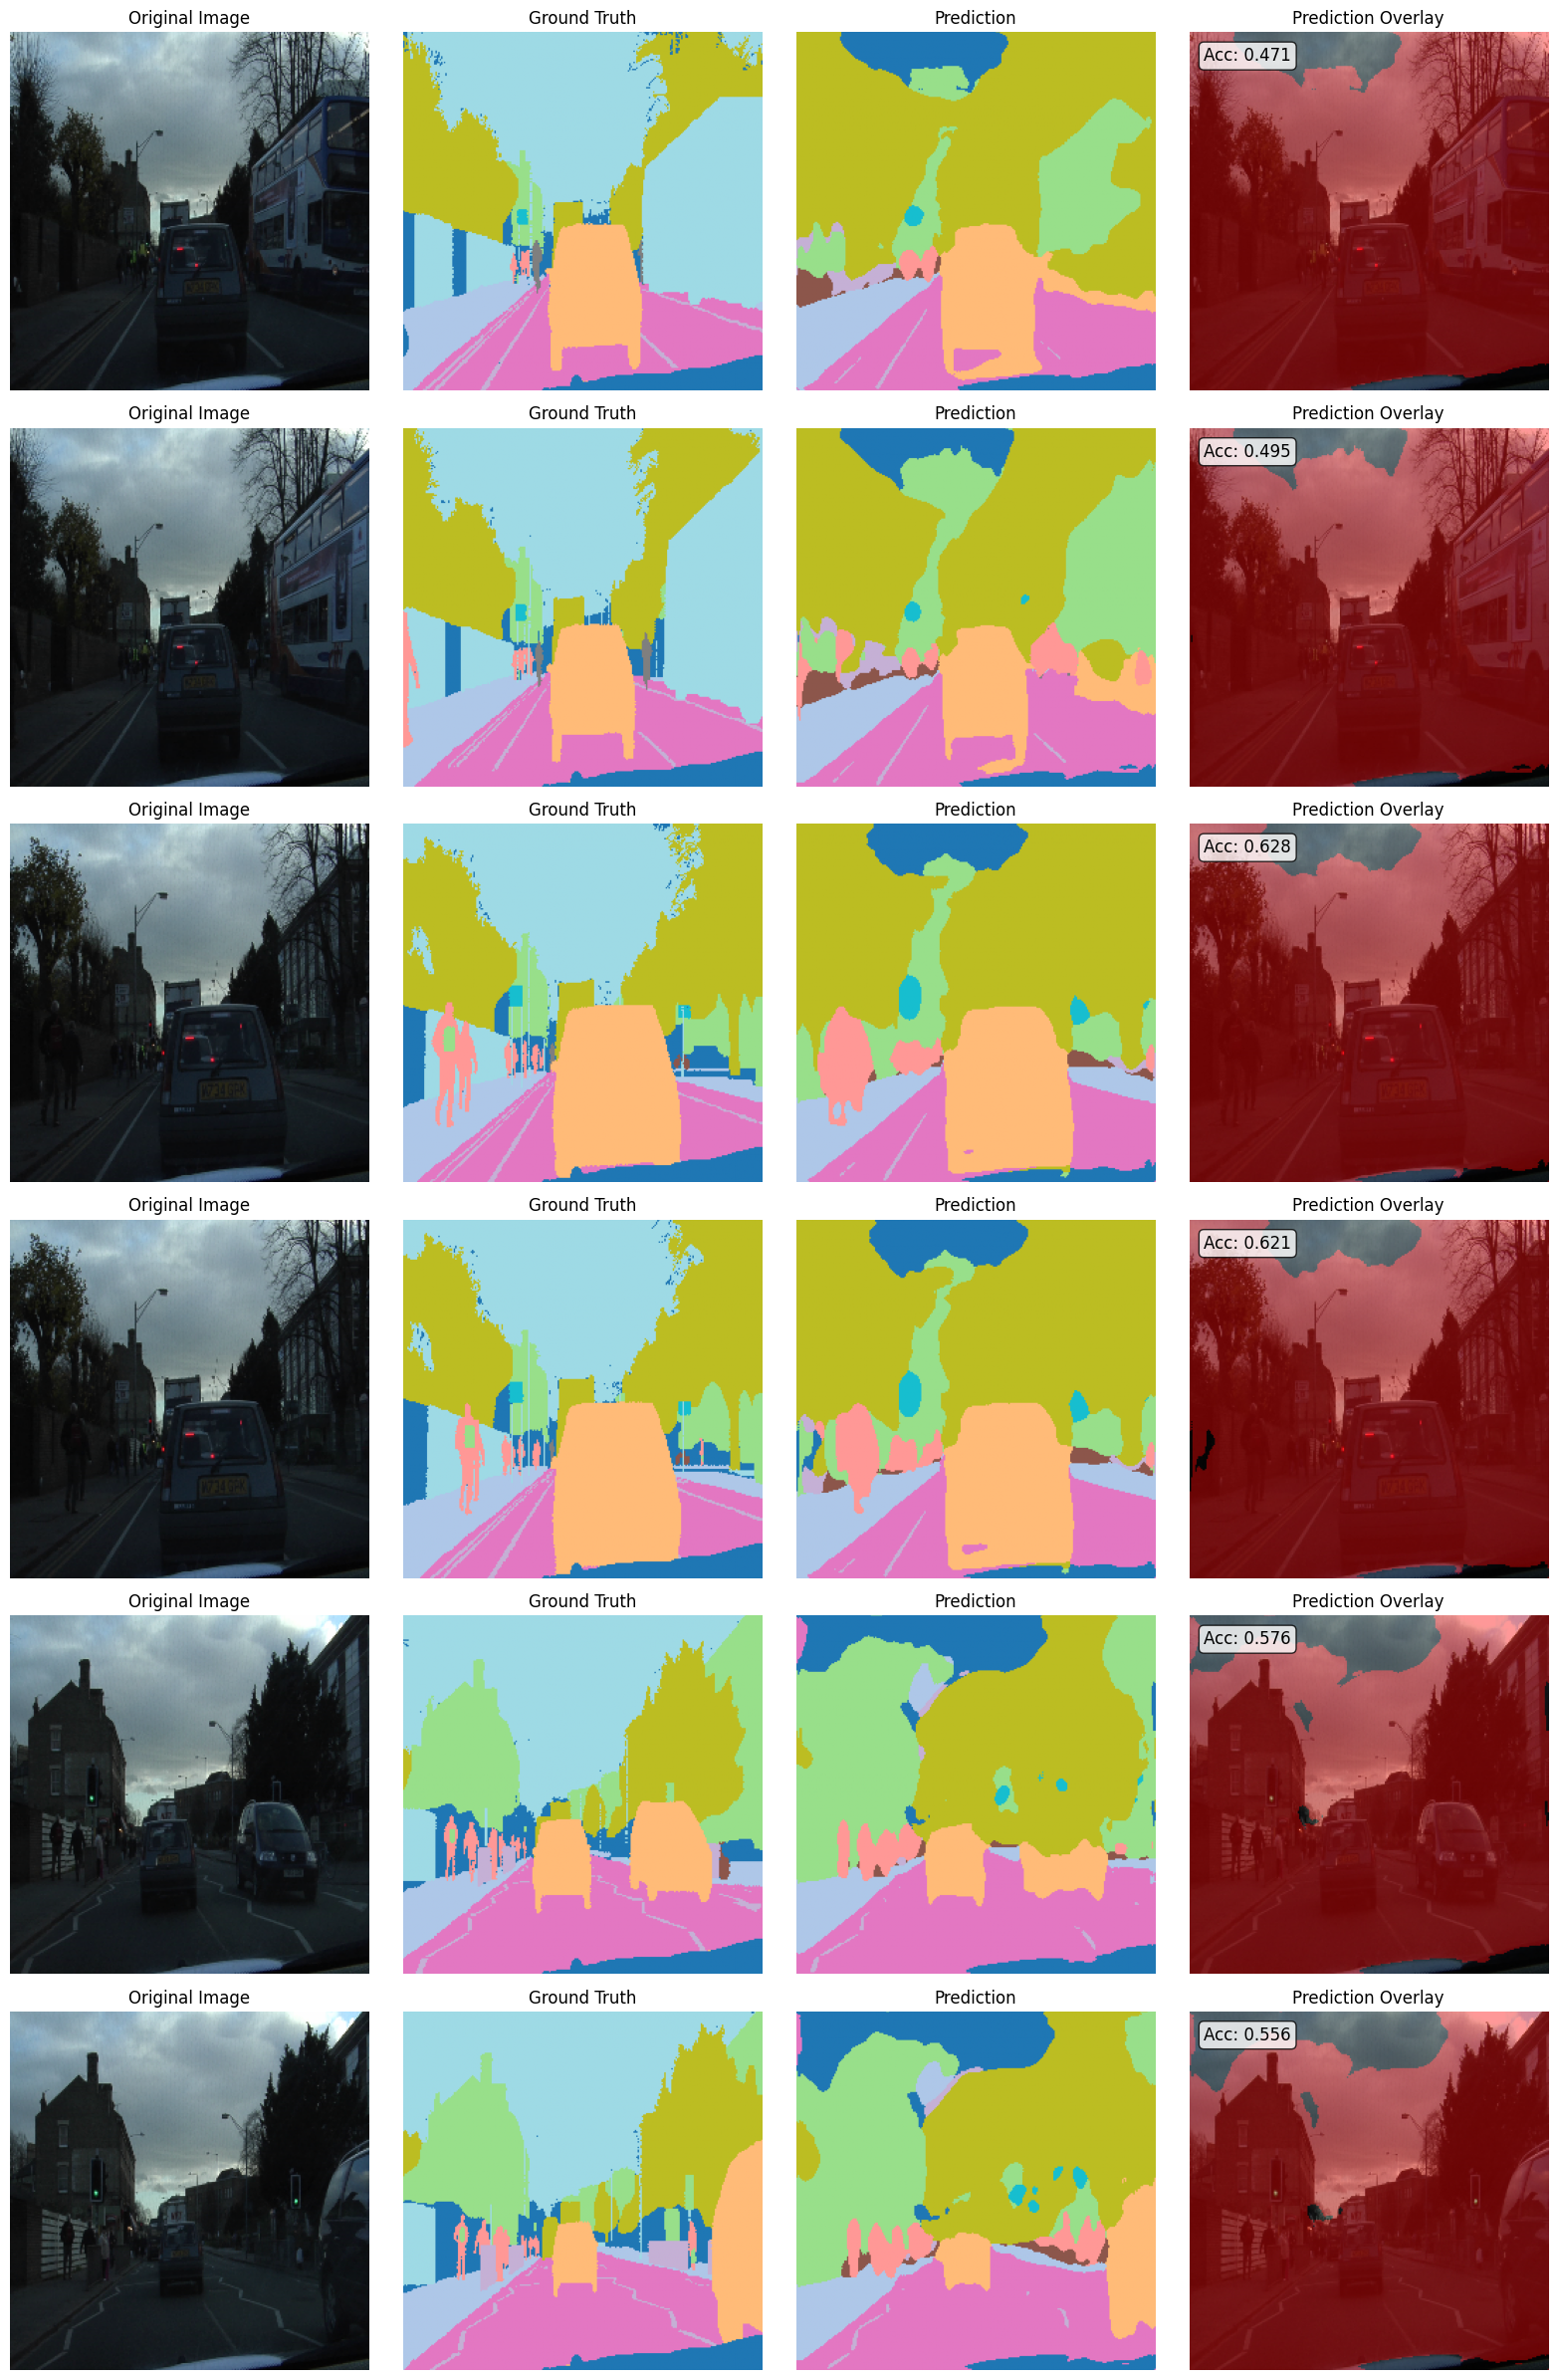

In [ ]:
unet_module.eval()
device = next(unet_module.parameters()).device

num_samples = 6
fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

with torch.no_grad():
    for idx in range(num_samples):
        image, mask = val_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)

        logits = unet_module(image_batch)
        pred = torch.argmax(logits, dim=1).cpu().squeeze()

        img_np = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)

        mask_np = mask.numpy()
        pred_np = pred.numpy()

        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(pred_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 2].set_title('Prediction')
        axes[idx, 2].axis('off')

        overlay = img_np.copy()
        pred_colored = np.zeros_like(img_np)
        pred_colored[pred_np > 0] = [1, 0, 0]
        overlay = overlay * 0.6 + pred_colored * 0.4

        axes[idx, 3].imshow(overlay)
        axes[idx, 3].set_title('Prediction Overlay')
        axes[idx, 3].axis('off')

        correct = (pred_np == mask_np).sum()
        total = mask_np.size
        pixel_acc = correct / total
        axes[idx, 3].text(10, 20, f'Acc: {pixel_acc:.3f}',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                          fontsize=12, color='black')

plt.tight_layout()
plt.show()


## Метрики на валидационном датасете

Вычисляем детальные метрики на валидационном датасете.


In [ ]:
def compute_metrics(preds, targets, n_classes=12):
    ious = []
    for cls in range(n_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)
        intersection = (pred_cls & target_cls).float().sum((1, 2))
        union = (pred_cls | target_cls).float().sum((1, 2))
        iou = (intersection + 1e-6) / (union + 1e-6)
        ious.append(iou.mean().item())

    mean_iou = np.mean(ious)

    correct = (preds == targets).float().sum((1, 2))
    total = targets.numel() // targets.shape[0]
    pixel_acc = correct.sum().item() / (targets.shape[0] * total)

    return {
        'mean_iou': mean_iou,
        'iou_per_class': ious,
        'pixel_acc': pixel_acc
    }

unet_module.eval()
all_preds = []
all_targets = []

val_loader_eval = DataLoader(
    val_dataset,
    batch_size=8 if torch.cuda.is_available() else 4,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

with torch.no_grad():
    for images, masks in tqdm(val_loader_eval, desc="Evaluating"):
        images = images.to(device)
        logits = unet_module(images)
        preds = torch.argmax(logits, dim=1).cpu()

        all_preds.append(preds)
        all_targets.append(masks)

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

metrics = compute_metrics(all_preds, all_targets, n_classes=12)

camvid_classes = ['Sky', 'Building', 'Column-Pole', 'Road', 'Sidewalk', 'Tree', 'Sign-Symbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Void']

print("="*60)
print("Validation Metrics:")
print("="*60)
print(f"Mean IoU: {metrics['mean_iou']:.4f}")
print(f"Pixel Accuracy: {metrics['pixel_acc']:.4f}")
print("\nIoU per class:")
for cls_name, iou in zip(camvid_classes, metrics['iou_per_class']):
    print(f"  {cls_name}: {iou:.4f}")
print("="*60)


Evaluating: 100%|██████████| 25/25 [00:45<00:00,  1.82s/it]


Validation Metrics:
Mean IoU: 0.3913
Pixel Accuracy: 0.7061

IoU per class:
  Sky: 0.0255
  Building: 0.6395
  Column-Pole: 0.5240
  Road: 0.6514
  Sidewalk: 0.2631
  Tree: 0.3793
  Sign-Symbol: 0.1757
  Fence: 0.9039
  Car: 0.5345
  Pedestrian: 0.3801
  Bicyclist: 0.2188
  Void: 0.0000
